In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import shutil
from pointer_utils import *

OpenCV version: 3.4.2
load yolov3-tiny-pointer.cfg backup_YOLO/yolov3-tiny-pointer_19000.weights
['dial', 'pointer']


In [3]:
import numpy as np

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    return result


In [4]:
frame, classIds, confidences, boxes = preprocess('20180412145714.jpg')

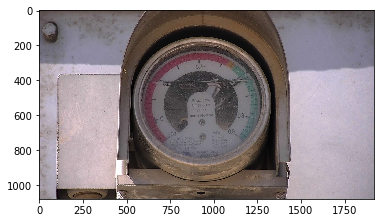

In [5]:
plt.imshow(frame)

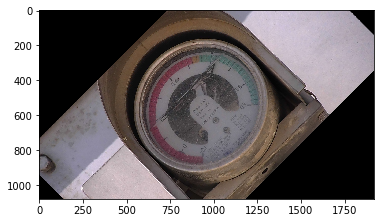

In [6]:
plt.imshow(rotateImage(frame, 45))

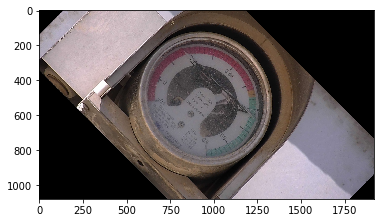

In [7]:
plt.imshow(rotateImage(frame, -45))

In [8]:
'''
for degree in range(-45,45):
    frame_rotated = rotateImage(frame, degree)
    cv.imwrite('mini_data/20180412145714_{}.jpg'.format(degree), cv.cvtColor(frame_rotated, cv.COLOR_RGB2BGR))
'''

"\nfor degree in range(-45,45):\n    frame_rotated = rotateImage(frame, degree)\n    cv.imwrite('mini_data/20180412145714_{}.jpg'.format(degree), cv.cvtColor(frame_rotated, cv.COLOR_RGB2BGR))\n"

In [9]:
image = frame
angle = 10

In [10]:
image_center = tuple(np.array(image.shape[1::-1]) / 2)
rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)


In [11]:
image_center

(960.0, 540.0)

In [12]:
image.shape

(1080, 1920, 3)

In [13]:
rot_mat

array([[ 9.84807753e-01,  1.73648178e-01, -7.91854588e+01],
       [-1.73648178e-01,  9.84807753e-01,  1.74906064e+02]])

In [14]:
result.shape

(1080, 1920, 3)

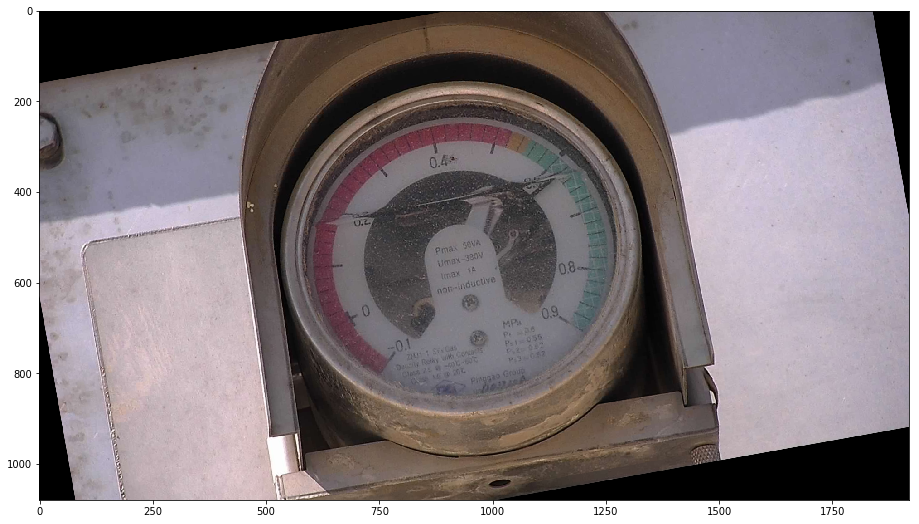

In [15]:
plt.figure(figsize=(16,9))
plt.imshow(result)

In [16]:
max_dial_idx, max_pointer_idx = extract_max(classIds, confidences)

In [17]:
dial_box = boxes[max_dial_idx]
pointer_box = boxes[max_pointer_idx]


In [18]:
pt = pointer_box
tail = (pt[0],pt[1]+pt[3])
head = (pt[0]+pt[2],pt[1])
tail_new = (rot_mat @ np.concatenate([tail,[1.0]])).astype(int).tolist()
head_new = (rot_mat @ np.concatenate([head,[1.0]])).astype(int).tolist()

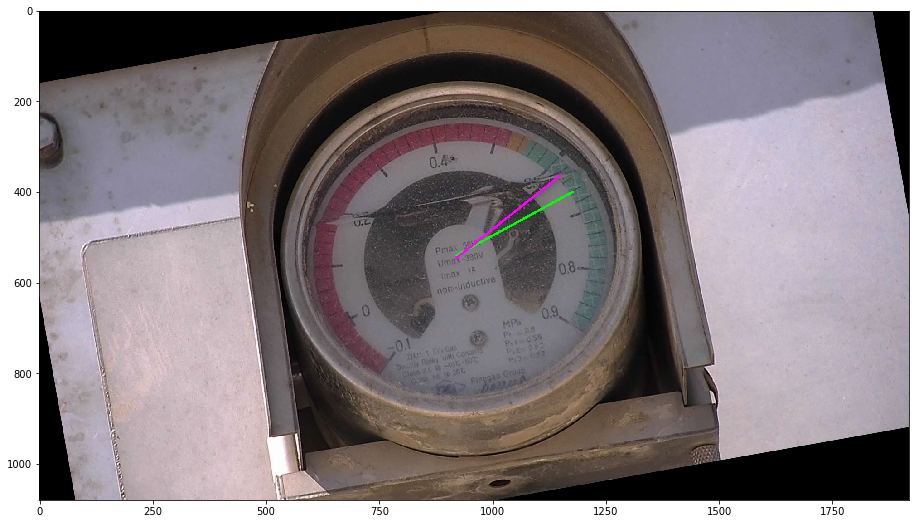

In [19]:
result_show = result.copy()
cv.line(result_show, tuple(tail), tuple(head), (0,255,0),3)
cv.line(result_show, tuple(tail_new), tuple(head_new), (255,0,255),3)

plt.figure(figsize=(16,9))
plt.imshow(result_show)
#cv.circle?

In [20]:
rotate_center = tail #tuple(np.array(image.shape[1::-1]) / 2)
angle = 30
rot_mat = cv.getRotationMatrix2D(rotate_center, angle, 1.0)
result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)


In [21]:
tail_new = (rot_mat @ np.concatenate([tail,[1.0]])).astype(int).tolist()
head_new = (rot_mat @ np.concatenate([head,[1.0]])).astype(int).tolist()

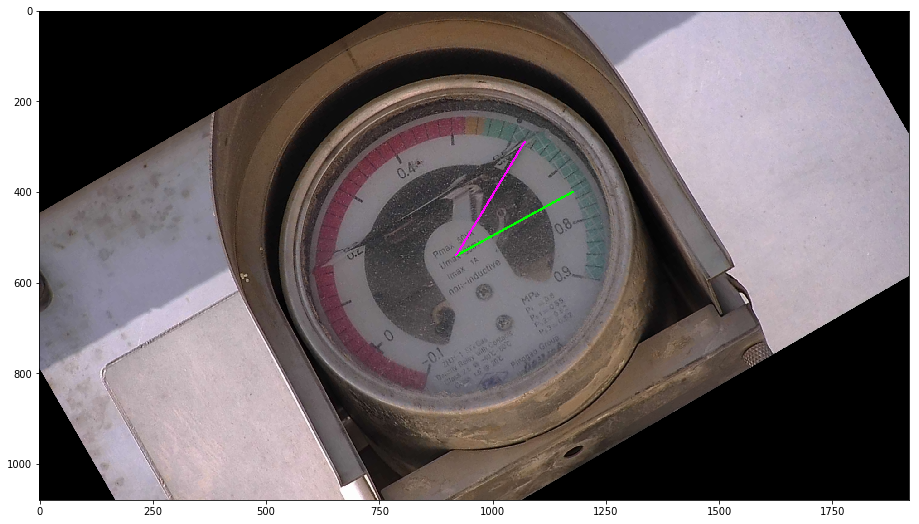

In [22]:
result_show = result.copy()
cv.line(result_show, tuple(tail), tuple(head), (0,255,0),3)
cv.line(result_show, tuple(tail_new), tuple(head_new), (255,0,255),3)

plt.figure(figsize=(16,9))
plt.imshow(result_show)


In [23]:
def show_YOLO(img_path, label_path, plt_show=True, cv_imwrite=False):
    frame = cv.imread(img_path)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    img_width = frame.shape[1]
    img_height = frame.shape[0]
    with open(label_path) as f:
        sl = f.read()
    for line in sl.split('\n'):
        if len(line) == 0:
            continue
        class_id, centerx, centery, width, height = line.strip().split(' ')
        class_id = int(class_id)
        centerx, centery, width, height = [float(n) for n in [centerx,centery,width,height]]
        left = centerx - width/2
        top = centery - height/2
        left = int(left * img_width)
        top = int(top * img_height)
        width = int(width * img_width)
        height = int(height * img_height)
        
        cv.rectangle(frame, (left,top),(left+width,top+height), (255,0,0), 2)
    
    if plt_show:
        plt.figure(figsize=(16,9))
        plt.imshow(frame)
    if cv_imwrite:
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        _, fname = os.path.split(img_path)
        cv.imwrite('data_rotated_show/'+fname, frame)

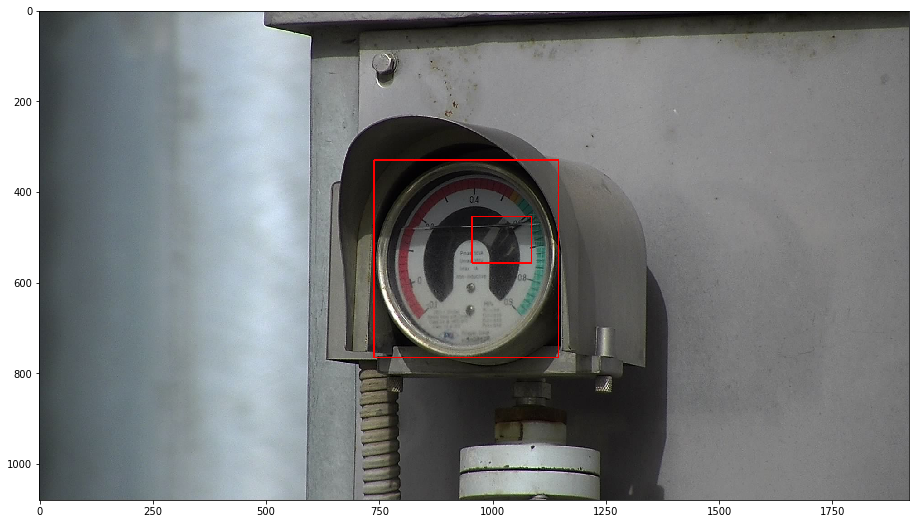

In [24]:
show_YOLO('data/20180326112844.jpg', 'data/20180326112844.txt')

In [25]:
def YOLO_label_decode(doc, img_width, img_height):
    rect_list = []
    for line in doc.split('\n'):
        line = line.strip()
        if len(line) == 0:
            continue
        class_id, centerx, centery, width, height = line.split(' ')
        class_id = int(class_id)
        centerx, centery, width, height = [float(n) for n in [centerx,centery,width,height]]
        left = centerx - width/2
        top = centery - height/2
        left = int(left * img_width)
        top = int(top * img_height)
        width = int(width * img_width)
        height = int(height * img_height)
        rect_list.append([class_id, left, top, width, height])
    return rect_list

def YOLO_label_encode(rect_list, img_width, img_height):
    lines = []
    for class_id, left, top, width, height in rect_list:
        centerx = (left + left + width)/2.0
        centery = (top  + top + height)/2.0
        
        centerx /= img_width
        centery /= img_height
        width /= img_width
        height /= img_height
        
        # https://github.com/ssaru/convert2Yolo/blob/master/Format.py#L592
        line = '{} {} {} {} {}'.format(class_id, round(centerx,3), round(centery,3), round(width,3), round(height,3))
        lines.append(line)
    doc = '\n'.join(lines) + '\n'
    return doc


In [26]:
with open('data/20180326112844.txt') as f:
    doc = f.read()
YOLO_label_decode(doc, frame.shape[1], frame.shape[0])

[[0, 739, 330, 407, 436], [1, 955, 455, 132, 102]]

In [27]:
def rotate_img_label(frame_source, label_source, frame_target, label_target, angle):
    #这个函数假设了只从只指向右上角的原始图像中读取，不过已经投入的加强图像.angle是角度制
    
    # decode
    frame = cv.imread(frame_source)
    with open(label_source) as f:
        doc = f.read()
    rects = YOLO_label_decode(doc, frame.shape[1], frame.shape[0])
    
    dial = None
    pt = None
    
    for class_id, left, top, width, height in rects:
        if class_id == 0:
            dial = (left, top, width, height)
        elif class_id == 1:
            pt = (left, top, width, height)
        else:
            raise Exception("Unknown object")
            
    if dial is None or pt is None:
        print('skip {}'.format(frame_source)) # 那种很模糊的，只标了dial的图像
        return None
        
    r = max(dial[2], dial[3])
    tail = (pt[0],pt[1]+pt[3])
    head = (pt[0]+pt[2],pt[1])
        
    
    # transform
    
    rotate_center = tail #tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(rotate_center, angle, 1.0)
    result = cv.warpAffine(frame, rot_mat, frame.shape[1::-1], flags=cv.INTER_LINEAR)
    
    tail_new = tuple((rot_mat @ np.concatenate([tail,[1.0]])).astype(int).tolist())
    head_new = tuple((rot_mat @ np.concatenate([head,[1.0]])).astype(int).tolist())
    
    pt_new_lefttop = (min(tail_new[0], head_new[0]), min(tail_new[1], head_new[1]))
    pt_new_rightbottom = (max(tail_new[0], head_new[0]), max(tail_new[1], head_new[1]))

    # encode
    
    dial_new = (tail_new[0]-r//2, tail_new[1]-r//2, r, r)
    pt_new = (pt_new_lefttop[0], pt_new_lefttop[1], 
              pt_new_rightbottom[0] - pt_new_lefttop[0], pt_new_rightbottom[1] - pt_new_lefttop[1])
    rect_list = [(0,)+dial_new, (1,)+pt_new]
    doc_new = YOLO_label_encode(rect_list, result.shape[1], result.shape[0])
    
    cv.imwrite(frame_target, result)
    with open(label_target, 'w') as f:
        f.write(doc_new)
    

In [28]:
rotate_img_label('data/20180326112844.jpg',         'data/20180326112844.txt', 
                 'data_rotated/20180326112844.jpg', 'annotation_rotated/20180326112844.txt',
                30)

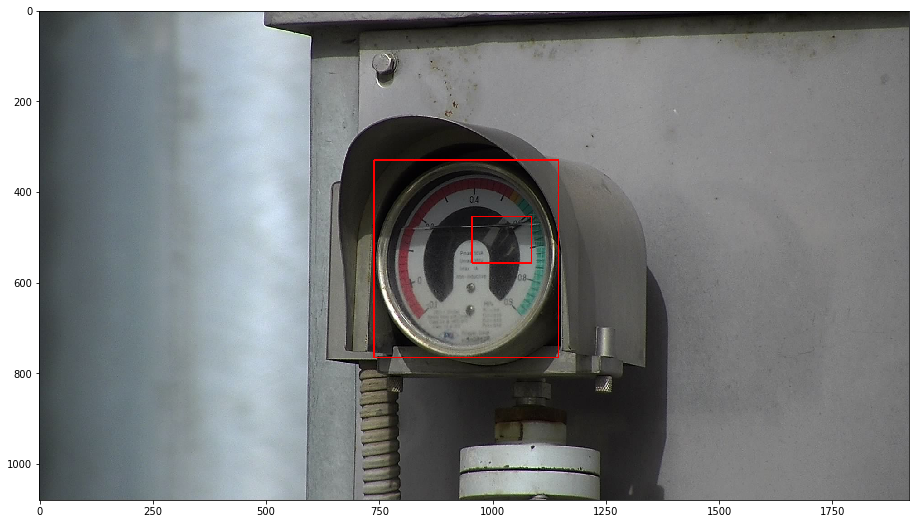

In [29]:
show_YOLO('data/20180326112844.jpg', 'data/20180326112844.txt')

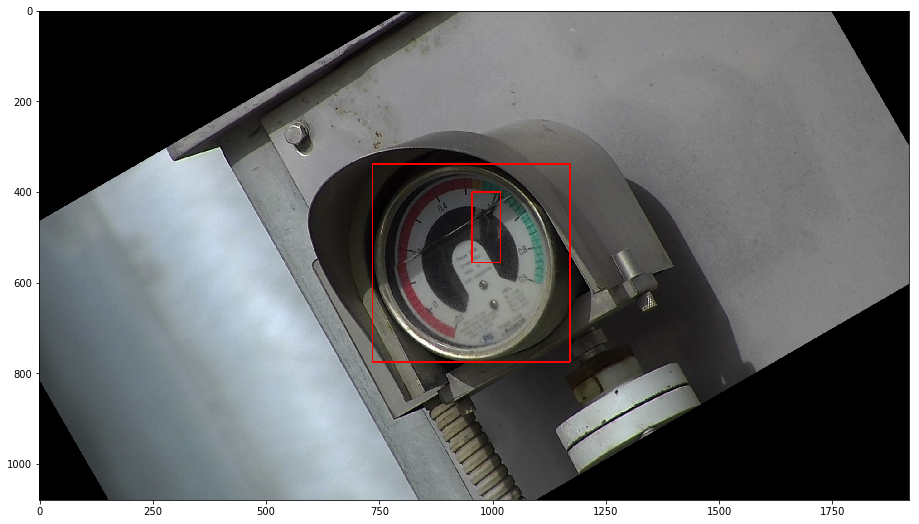

In [30]:
show_YOLO('data_rotated/20180326112844.jpg', 'annotation_rotated/20180326112844.txt')

In [190]:
fname_list = []
for fname in os.listdir('data'):
    #print(fname, fname.endswith('.txt') , 'mult' not in fname , 'none' not in fname)
    if fname.endswith('.txt') and 'mult' not in fname and 'none' not in fname:
        fname_list.append(fname)

In [192]:
len(fname_list)

216

每个样本用随机的三个-90度到90度的一个变换。

In [199]:
del pt,tail, head

In [204]:
for fname in fname_list:
    name, ext = os.path.splitext(fname)
    
    frame_source = os.path.join('data', name+'.jpg')
    label_source = os.path.join('data', fname)
    
    frame_target = os.path.join('data_rotated', name+'_angle={}'+'.jpg')
    label_target = os.path.join('annotation_rotated', name+'_angle={}'+'.txt')
    
    for angle in np.random.randint(-90,90,3):
        rotate_img_label(frame_source, label_source, frame_target.format(angle), label_target.format(angle), angle)
        
    
    

skip data\20180406154309.jpg
skip data\20180406154309.jpg
skip data\20180406154309.jpg
skip data\20180407105828_14_6.jpg
skip data\20180407105828_14_6.jpg
skip data\20180407105828_14_6.jpg
skip data\20180412145948.jpg
skip data\20180412145948.jpg
skip data\20180412145948.jpg
skip data\20180414160811.jpg
skip data\20180414160811.jpg
skip data\20180414160811.jpg
skip data\20180419214442_13_6.jpg
skip data\20180419214442_13_6.jpg
skip data\20180419214442_13_6.jpg
skip data\20180512155436.jpg
skip data\20180512155436.jpg
skip data\20180512155436.jpg
skip data\20180517161128.jpg
skip data\20180517161128.jpg
skip data\20180517161128.jpg
skip data\20180521155201.jpg
skip data\20180521155201.jpg
skip data\20180521155201.jpg
skip data\20180601162655.jpg
skip data\20180601162655.jpg
skip data\20180601162655.jpg
skip data\20180602163851.jpg
skip data\20180602163851.jpg
skip data\20180602163851.jpg
skip data\20181105104043.jpg
skip data\20181105104043.jpg
skip data\20181105104043.jpg


In [206]:
for fname in os.listdir('data_rotated'):
    img_path = os.path.join('data_rotated', fname)
    name, ext = os.path.splitext(fname)
    label_path = os.path.join('annotation_rotated', name+'.txt')
    show_YOLO(img_path, label_path, plt_show=False, cv_imwrite=True)